Setup and Discretization

In [2]:
!pip install swig > /dev/null
!pip install gymnasium[box2d] box2d-py==2.3.5 pygame==2.1.3 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 72.3 MB/s eta 0:00:00


**SARSA**

Discretization

In [3]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

# SARSA parameters
alpha = 0.1
gamma = 0.95
epsilon = 0.2
episodes = 2000

# Discretization bins
bins = [6, 6, 6, 6, 6, 6, 2, 2]  # for 8-dimensional state space

# Discretize a single observation
def discretize_state(state):
    upper_bounds = [1, 1, 1, 1, 1, 1, 1, 1]
    lower_bounds = [-1, -1, -1, -1, -1, -1, 0, 0]
    ratios = [(state[i] - lower_bounds[i]) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
    new_obs = [int(round((bins[i] - 1) * ratios[i])) for i in range(len(state))]
    new_obs = [min(bins[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
    return tuple(new_obs)

# Epsilon-greedy policy
def epsilon_greedy(Q, state, n_actions, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[state])

# SARSA(0) algorithm
def sarsa(env, episodes, alpha, gamma, epsilon):
    n_actions = env.action_space.n
    Q = {}
    returns = []

    for ep in range(episodes):
        total_reward = 0
        state, _ = env.reset()
        state_discrete = discretize_state(state)
        if state_discrete not in Q:
            Q[state_discrete] = np.zeros(n_actions)
        action = epsilon_greedy(Q, state_discrete, n_actions, epsilon)

        done = False
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            next_state_discrete = discretize_state(next_state)

            if next_state_discrete not in Q:
                Q[next_state_discrete] = np.zeros(n_actions)

            next_action = epsilon_greedy(Q, next_state_discrete, n_actions, epsilon)
            Q[state_discrete][action] += alpha * (reward + gamma * Q[next_state_discrete][next_action] - Q[state_discrete][action])

            state_discrete = next_state_discrete
            action = next_action

        returns.append(total_reward)
        if (ep+1) % 100 == 0:
            print(f"Episode {ep+1}/{episodes}, Total Reward: {total_reward}")

    return Q, returns


Simulate Learned Policy After Training

In [4]:
def simulate_policy(env, Q):
    state, _ = env.reset()
    total_reward = 0
    done = False
    state_discrete = discretize_state(state)
    steps = 0

    while not done:
        env.render()
        if state_discrete not in Q:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state_discrete])
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state_discrete = discretize_state(next_state)
        steps += 1
        time.sleep(0.02)

    env.close()
    print(f"Total reward: {total_reward}, Steps: {steps}")


Plot Returns

Episode 100/2000, Total Reward: -208.60276847609768
Episode 200/2000, Total Reward: -110.0969448759417
Episode 300/2000, Total Reward: -238.44157047042413
Episode 400/2000, Total Reward: -24.42507626520502
Episode 500/2000, Total Reward: -172.08451328726218
Episode 600/2000, Total Reward: -112.29021776865198
Episode 700/2000, Total Reward: -115.28259542027494
Episode 800/2000, Total Reward: -91.48693740980825
Episode 900/2000, Total Reward: -9.128789599590732
Episode 1000/2000, Total Reward: -81.15607099723432
Episode 1100/2000, Total Reward: -170.8395656068982
Episode 1200/2000, Total Reward: -56.760319492746305
Episode 1300/2000, Total Reward: -49.54725104342509
Episode 1400/2000, Total Reward: -242.45161799805715
Episode 1500/2000, Total Reward: -82.42455241185237
Episode 1600/2000, Total Reward: -87.01034480606226
Episode 1700/2000, Total Reward: -103.17126488291932
Episode 1800/2000, Total Reward: -73.39105655408892
Episode 1900/2000, Total Reward: 53.98492285984997
Episode 2000/2

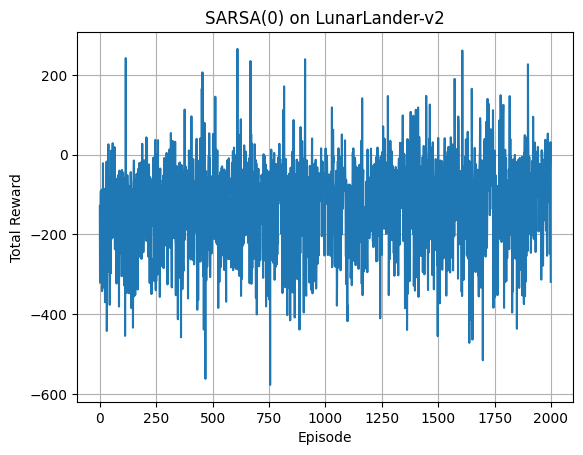

In [5]:
env = gym.make("LunarLander-v3", render_mode=None)
Q_sarsa_lunar, returns_lunar = sarsa(env, episodes, alpha, gamma, epsilon)

plt.plot(returns_lunar)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA(0) on LunarLander-v2")
plt.grid()
plt.show()


Test Learned Policy

In [6]:
env = gym.make("LunarLander-v3", render_mode=None)
simulate_policy(env, Q_sarsa_lunar)

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/box2d/lunar_lander.py:672: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("LunarLander-v3", render_mode="rgb_array")
  gym.logger.warn(


Total reward: -113.73494469122754, Steps: 1000


**Q-Learning**

In [7]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time

# Hyperparameters
alpha = 0.1        # learning rate
gamma = 0.95       # discount factor
epsilon = 0.2      # exploration factor
episodes = 2000    # total training episodes
n_bins = 6         # number of bins per state dimension

env = gym.make("LunarLander-v3")

# Discretize state space
obs_space = env.observation_space
low = obs_space.low
high = obs_space.high
bins = [np.linspace(low[i], high[i], n_bins - 1) for i in range(len(low))]

def discretize_state(state):
    return tuple(np.digitize(s, bins[i]) for i, s in enumerate(state))

# Initialize Q-table
q_table = np.zeros([n_bins] * len(low) + [env.action_space.n])


Q-Learning Algorithm

In [8]:
def epsilon_greedy(state, q_table, epsilon):
    if np.random.random() < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(q_table[state])

qlearning_returns = []

for ep in range(episodes):
    state, _ = env.reset()
    d_state = discretize_state(state)
    total_reward = 0

    done = False
    while not done:
        action = epsilon_greedy(d_state, q_table, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        d_next_state = discretize_state(next_state)

        # Q-learning update
        best_next_action = np.max(q_table[d_next_state])
        q_table[d_state + (action,)] += alpha * (reward + gamma * best_next_action - q_table[d_state + (action,)])

        d_state = d_next_state
        total_reward += reward

    qlearning_returns.append(total_reward)

    if (ep + 1) % 100 == 0:
        print(f"Episode {ep+1}: Reward = {total_reward:.2f}")


Episode 100: Reward = -157.93
Episode 200: Reward = -66.31
Episode 300: Reward = -68.53
Episode 400: Reward = -210.86
Episode 500: Reward = -195.61
Episode 600: Reward = -342.26
Episode 700: Reward = -47.15
Episode 800: Reward = -109.74
Episode 900: Reward = -106.80
Episode 1000: Reward = -218.42
Episode 1100: Reward = 38.53
Episode 1200: Reward = -279.75
Episode 1300: Reward = -64.86
Episode 1400: Reward = 23.81
Episode 1500: Reward = -318.46
Episode 1600: Reward = -84.54
Episode 1700: Reward = -27.62
Episode 1800: Reward = -152.17
Episode 1900: Reward = -98.98
Episode 2000: Reward = -85.24


Plot the Returns

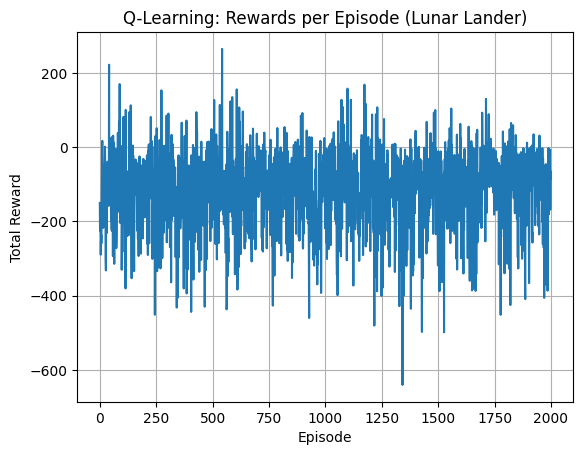

In [9]:
plt.plot(qlearning_returns)
plt.title("Q-Learning: Rewards per Episode (Lunar Lander)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()

Simulate the Learned Strategy

In [10]:
def run_learned_policy(q_table, episodes=5, render=False):
    total_steps = []
    for _ in range(episodes):
        state, _ = env.reset()
        d_state = discretize_state(state)
        done = False
        step = 0
        while not done:
            if render:
                env.render()
            action = np.argmax(q_table[d_state])
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            d_state = discretize_state(next_state)
            step += 1
        total_steps.append(step)
    return total_steps

# Test learned policy
start_time = time.time()
steps_taken = run_learned_policy(q_table, episodes=5, render=False)
end_time = time.time()

print(f"Average steps to solve (Q-learning): {np.mean(steps_taken)}")
print(f"Total evaluation time: {end_time - start_time:.2f} seconds")


Average steps to solve (Q-learning): 192.2
Total evaluation time: 0.11 seconds


Comparison with SARSA

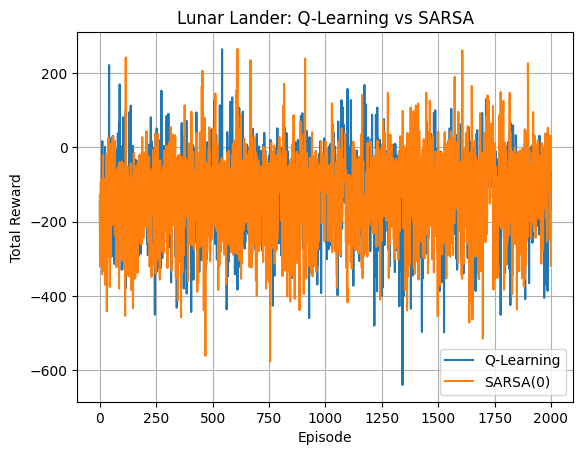

In [11]:
plt.plot(qlearning_returns, label="Q-Learning")
plt.plot(returns_lunar, label="SARSA(0)")
plt.title("Lunar Lander: Q-Learning vs SARSA")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid()
plt.show()

SARSA(λ) with Eligibility Traces for Lunar Lander

In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict

def epsilon_greedy_policy(Q, state, epsilon, action_space):
    if np.random.rand() < epsilon or state not in Q:
        return action_space.sample()
    return max(Q[state], key=Q[state].get)

def sarsa_lambda(env, episodes, alpha, gamma, epsilon, lambda_):
    Q = defaultdict(lambda: defaultdict(float))
    returns = []

    for episode in range(episodes):
        state, _ = env.reset()
        state = tuple(np.round(state, 1))  # discretize
        action = epsilon_greedy_policy(Q, state, epsilon, env.action_space)
        E = defaultdict(lambda: defaultdict(float))
        total_reward = 0

        done = False
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = tuple(np.round(next_state, 1))
            done = terminated or truncated
            next_action = epsilon_greedy_policy(Q, next_state, epsilon, env.action_space)
            delta = reward + gamma * Q[next_state][next_action] - Q[state][action]
            E[state][action] += 1

            for s in Q:
                for a in Q[s]:
                    Q[s][a] += alpha * delta * E[s][a]
                    E[s][a] *= gamma * lambda_

            state, action = next_state, next_action
            total_reward += reward

        returns.append(total_reward)
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode+1}: Total reward = {total_reward}")

    return Q, returns


 Plot and Simulation

In [ ]:
# Hyperparameters
episodes = 2000
alpha = 0.1
gamma = 0.95
epsilon = 0.2
lambda_ = 0.8

env = gym.make("LunarLander-v3")

Q_lambda, lambda_returns = sarsa_lambda(env, episodes, alpha, gamma, epsilon, lambda_)

# Plot the returns
plt.figure(figsize=(10, 5))
plt.plot(lambda_returns, label="SARSA(λ)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("SARSA(λ) - Lunar Lander")
plt.legend()
plt.grid()
plt.show()


Episode 100: Total reward = -297.261084645903
Episode 200: Total reward = -73.59827461663606


Simulate Learned Strategy

In [ ]:
def simulate_policy(env, Q):
    state, _ = env.reset()
    state = tuple(np.round(state, 1))
    total_reward = 0
    done = False
    start_time = time.time()

    while not done:
        action = max(Q[state], key=Q[state].get) if state in Q else env.action_space.sample()
        next_state, reward, terminated, truncated, _ = env.step(action)
        next_state = tuple(np.round(next_state, 1))
        done = terminated or truncated
        total_reward += reward
        state = next_state

    duration = time.time() - start_time
    return total_reward, duration

# Run without rendering due to video device limitations
reward_lambda, time_lambda = simulate_policy(env, Q_lambda)
print(f"SARSA(λ) Achieved reward: {reward_lambda} in {time_lambda:.2f} seconds")


Comparison with SARSA(0) and Q-learning

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(qlearn_returns, label="Q-Learning")
plt.plot(sarsa_returns, label="SARSA(0)")
plt.plot(lambda_returns, label="SARSA(λ)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Comparison of RL Algorithms - Lunar Lander")
plt.legend()
plt.grid()
plt.show()